In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt

import sys
sys.path.insert(0, '/home/sahre/git_repositories/APDFT/prototyping/atomic_energies/')
import utils_qm as uqm
import bt_tools as bt

import importlib
importlib.reload(bt)

from IPython.display import display, Latex

In [5]:
490-270

220

In [2]:
def predictions_template(data, model, b_param_dict, c_param_dict, Z0_dict, Z_ref_dict):
    """
    test different models
    """
    Z_ABC = {2:[], 3:[], 4:[]}
    deltaE_ref = {2:[], 3:[], 4:[]}
    deltaE_model = {2:[], 3:[], 4:[]}
    
    for n in [2,3,4]:

        
        Z_ref = Z_ref_dict[n]
        b = b_param_dict[n]
        c = c_param_dict[n]
        Z0 = Z0_dict[n]
        
        for ZA in Z_ref:
                for ZB in Z_ref:
                    for ZC in Z_ref:
                        if ZB<ZC:
                            if ZA <= ZB:
                                E_AB = -630*data.loc[(data['Z1']==ZA) & (data['Z2']==ZB), 'bfe'].item()
                            else:
                                E_AB = -630*data.loc[(data['Z1']==ZB) & (data['Z2']==ZA), 'bfe'].item()
                            if ZA <= ZC:
                                E_AC = -630*data.loc[(data['Z1']==ZA) & (data['Z2']==ZC), 'bfe'].item()
                            else:
                                E_AC = -630*data.loc[(data['Z1']==ZC) & (data['Z2']==ZA), 'bfe'].item()

                            Z_ABC[n].append([ZA, ZB, ZC])
                            deltaE_ref[n].append(E_AB - E_AC)
                            deltaE_model[n].append(model(ZA, ZB, ZC, b, c, Z0))
                            
        Z_ABC[n] = np.array(Z_ABC[n])
        deltaE_ref[n] = np.array(deltaE_ref[n])
        deltaE_model[n] = np.array(deltaE_model[n])
                            
    return(Z_ABC, deltaE_ref, deltaE_model)

def prediction_row(n, data, model, b_param_dict, c_param_dict, Z0_dict, Z_ref_dict):
    Z_ref = Z_ref_dict[n]
    b = b_param_dict[n]
    c = c_param_dict[n]
    Z0 = Z0_dict[n]
    
    Z_ABC = []
    deltaE_ref= []
    deltaE_model= []

    for ZA in Z_ref:
            for ZB in Z_ref:
                for ZC in Z_ref:
                    if ZB<ZC:
                        if ZA <= ZB:
                            E_AB = -630*data.loc[(data['Z1']==ZA) & (data['Z2']==ZB), 'bfe'].item()
                        else:
                            E_AB = -630*data.loc[(data['Z1']==ZB) & (data['Z2']==ZA), 'bfe'].item()
                        if ZA <= ZC:
                            E_AC = -630*data.loc[(data['Z1']==ZA) & (data['Z2']==ZC), 'bfe'].item()
                        else:
                            E_AC = -630*data.loc[(data['Z1']==ZC) & (data['Z2']==ZA), 'bfe'].item()

                        Z_ABC.append([ZA, ZB, ZC])
                        deltaE_ref.append(E_AB - E_AC)
                        deltaE_model.append(model(ZA, ZB, ZC, b, c, Z0))

    Z_ABC = np.array(Z_ABC)
    deltaE_ref= np.array(deltaE_ref)
    deltaE_model = np.array(deltaE_model)
    
    return(Z_ABC, deltaE_ref, deltaE_model)

In [3]:
data = pd.read_csv('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/energies_homolytic.csv')

Z_ref_dict = {2:[6,7,8,9], 3:[14,15,16,17], 4:[32,33,34,35]}
b_param_dict = {2:630-619.5300386670592, 3:630-621.177360870767, 4:630-623.8201873437458}
c_param_dict = {2:1.9867938212838283, 3:1.4955960933741659, 4:0.8130818647886249}
Z0_dict = {2:7.8, 3:14.3, 4:33.9}

## Model 1

$\Delta E_{ABC} = [\eta - b Z_A + \mu (Z_B + Z_C) ] \Delta Z $

$\Delta Z = Z_B - Z_C$

$\eta = -\frac{7}{9} Z_0^{4/3} c$

$\mu = \frac{28}{18} Z_0^{1/3} c$

In [5]:
def model_1(ZA, ZB, ZC, b, c, Z0):
    deltaZ = ZB - ZC
    eta = -7/9*Z0**(4/3)*c
    mu = 28/18*Z0**(1/3)*c
    
    deltaE = (eta-b*ZA + mu*(ZB+ZC))*deltaZ
#     E_AB = -b*ZA*ZB + c*(-7/9*Z0**(4/3)*(ZA+ZB)+28/18*Z0**(1/3)*(ZA**2+ZB**2))
#     E_AC = -b*ZA*ZC + c*(-7/9*Z0**(4/3)*(ZA+ZC)+28/18*Z0**(1/3)*(ZA**2+ZC**2))
# #     E_AC = a  + 4/9*Z0**(7/3)*c - 7/9*Z0**(4/3)*c*(ZA+ZC) - b*ZA*ZC+28/18*Z0**(1/3)*c*(ZA**2+ZC**2)
    
#     deltaE = E_AB - E_AC
    return(deltaE)

Z_ABC, deltaE_ref, deltaE_model1 = predictions_template(data, model_1, b_param_dict, c_param_dict, Z0_dict, Z_ref_dict)

1.7412887965134656
2.6908192984059873
2.4945183338969374


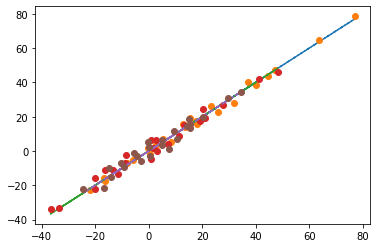

In [6]:
MAE = 0
for n in [2,3,4]:
    plt.plot(deltaE_ref[n], deltaE_ref[n], '--')
    plt.plot(deltaE_ref[n], deltaE_model1[n], 'o')
    
    MAE += (np.abs(deltaE_ref[n]-deltaE_model1[n])).mean()
    print((np.abs(deltaE_ref[n]-deltaE_model1[n])).mean())

In [7]:
MAE/3


2.30887547627213

## Model 2

$\Delta E_{ABC} = \eta \Delta Z + (2\mu - b) Z_A \Delta Z+ \mu \left((Z_A - Z_B)^2  - (Z_A - Z_C)^2 \right) $

$\Delta Z = Z_B - Z_C$

$\eta = -\frac{7}{9} Z_0^{4/3} c$

$\mu = \frac{14}{9} Z_0^{1/3} c$

In [8]:
def model_2(ZA, ZB, ZC, b, c, Z0):
    deltaZ = ZB - ZC
    eta = -7/9*Z0**(4/3)*c
    mu = 14/9*Z0**(1/3)*c
    
    deltaE = eta*deltaZ + (2*mu-b)*ZA*deltaZ + mu*((ZA-ZB)**2 - (ZA-ZC)**2)
#     E_AB = -b*ZA*ZB + c*(-7/9*Z0**(4/3)*(ZA+ZB)+28/18*Z0**(1/3)*(ZA**2+ZB**2))
#     E_AC = -b*ZA*ZC + c*(-7/9*Z0**(4/3)*(ZA+ZC)+28/18*Z0**(1/3)*(ZA**2+ZC**2))
# #     E_AC = a  + 4/9*Z0**(7/3)*c - 7/9*Z0**(4/3)*c*(ZA+ZC) - b*ZA*ZC+28/18*Z0**(1/3)*c*(ZA**2+ZC**2)
    
#     deltaE = E_AB - E_AC
    return(deltaE)

Z_ABC, deltaE_ref, deltaE_model2 = predictions_template(data, model_2, b_param_dict, c_param_dict, Z0_dict, Z_ref_dict)

1.7412887965134658
2.69081929840598
2.494518333896942


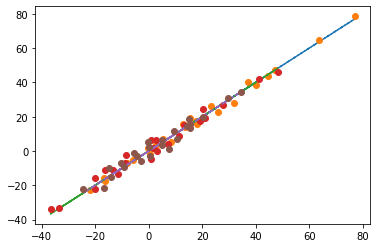

In [9]:
MAE = 0
for n in [2,3,4]:
    plt.plot(deltaE_ref[n], deltaE_ref[n], '--')
    plt.plot(deltaE_ref[n], deltaE_model2[n], 'o')
    
    MAE += (np.abs(deltaE_ref[n]-deltaE_model2[n])).mean()
    print((np.abs(deltaE_ref[n]-deltaE_model2[n])).mean())

In [10]:
for n in [2,3,4]:
    Z0_dict = {2:7.5, 3:15.5, 4:33.5}
    eta = 7/9*Z0_dict[n]**(4/3)*c_param_dict[n]
    mu = 14/9*Z0_dict[n]**(1/3)*c_param_dict[n]
    kappa = 2*mu - b_param_dict[n]
    
    print('##############################')
    print(f'n = {n}')
    
    
    display(Latex(f'$\eta = {np.round(eta,1)} $'))
    
    display(Latex(f'$2 \mu -b = {np.round(kappa,1)} $'))
    
    display(Latex(f'$\mu = {np.round(mu,1)} $'))

##############################
n = 2


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

##############################
n = 3


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

##############################
n = 4


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### optimize $Z_0$

In [ ]:
Z0_2 = np.linspace(6, 9, 50)
Z0_3 = np.linspace(14, 17, 50)
Z0_4 = np.linspace(32, 35, 50)

Z0_grid = {2:Z0_2, 3:Z0_3, 4:Z0_4}

num_opt = 50
for n in [2,3,4]:
    MAE = []
    for i in range(num_opt):
        Z0_dict[n] = Z0_grid[n][i]
        ZABC, deltaE_ref, deltaE_model = prediction_row(n, data, model_2, b_param_dict, c_param_dict, Z0_dict, Z_ref_dict)

        MAE.append((np.abs(deltaE_ref - deltaE_model)).mean())

    plt.plot(Z0_grid[n], MAE)
    print(min(MAE))
    print( Z0_grid[n][MAE.index(min(MAE))] )

In [ ]:
for k in Z0_dict.keys():
    eta = -7/9*Z0_dict[k]**(4/3)*c_param_dict[k]
    mu = 28/18*Z0_dict[k]**(1/3)*c_param_dict[k]
    
    print('##########################################')
    print(f'n = {k}')
    display(Latex(f'$\eta = {np.round(eta,1)} $'))
    
    display(Latex(f'$2 \mu -b = {np.round(2*mu-b_param_dict[k],1)} $'))
    
    display(Latex(f'$\mu = {np.round(mu,1)} $'))


## Model 3 Anatole's version

$\Delta E_{ABC} = -\eta (n-1) \Delta Z - (8.5 +(n-3)^2) Z_A \Delta Z + 6 (Z_B^2 - Z_C^2) $

$\Delta Z = Z_B - Z_C$

$\eta = -\frac{7}{9} Z_0^{4/3} c$

$\mu = \frac{14}{9} Z_0^{1/3} c$

In [17]:
def model_3(ZA, ZB, ZC, n, dummy1, dummy2):
    deltaZ = ZB - ZC
    eta_tilde = 28
    kappa_tilde = (n-3)**2 -3.5
    mu_tilde = 6
    
    #deltaE = -eta_tilde*(n-1)*deltaZ - kappa_tilde*ZA*deltaZ + mu_tilde*((ZA-ZB)**2 - (ZA-ZC)**2)
    
    deltaE = -eta_tilde*(n-1)*deltaZ - (8.5+(n-3)**2)*ZA*deltaZ+6*(ZB**2-ZC**2)
    
    return(deltaE)

Z_ABC, deltaE_ref, deltaE_model3 = predictions_template(data, model_3, {2:2, 3:3, 4:4}, c_param_dict, Z0_dict, Z_ref_dict)

2.643962676106638
3.0391366661022055
6.9996662802416365


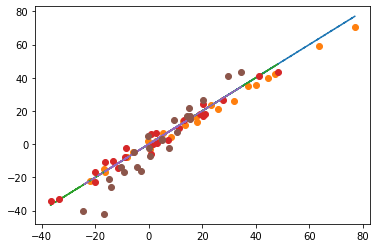

In [18]:
MAE = 0
for n in [2,3,4]:
    plt.plot(deltaE_ref[n], deltaE_ref[n], '--')
    plt.plot(deltaE_ref[n], deltaE_model3[n], 'o')
    
    MAE += (np.abs(deltaE_ref[n]-deltaE_model3[n])).mean()
    print((np.abs(deltaE_ref[n]-deltaE_model3[n])).mean())

In [19]:
MAE/3

4.227588540816826

In [25]:
len(deltaE_ref[4])

24

In [26]:
24*3

72

In [19]:
model_3(32, 32, 35, 4, 0, 0)

-42.0

In [15]:
deltaE_model3[4] - deltaE_ref[4]

array([ -9.75312249, -13.28494897, -25.21961212,  -3.53182648,
       -15.46648963, -11.93466315,  -3.11082789,  -1.93111703,
        -9.08601979,   1.17971086,  -5.9751919 ,  -7.15490276,
         1.60070946,   6.78748848,  -0.58672467,   5.18677903,
        -2.18743412,  -7.37421315,   6.38046984,  11.34793848,
         8.97686317,   4.96746864,   2.59639333,  -2.37107531])

In [17]:
Z_ABC[4]

array([[32, 32, 33],
       [32, 32, 34],
       [32, 32, 35],
       [32, 33, 34],
       [32, 33, 35],
       [32, 34, 35],
       [33, 32, 33],
       [33, 32, 34],
       [33, 32, 35],
       [33, 33, 34],
       [33, 33, 35],
       [33, 34, 35],
       [34, 32, 33],
       [34, 32, 34],
       [34, 32, 35],
       [34, 33, 34],
       [34, 33, 35],
       [34, 34, 35],
       [35, 32, 33],
       [35, 32, 34],
       [35, 32, 35],
       [35, 33, 34],
       [35, 33, 35],
       [35, 34, 35]])

## optimize model 3

In [ ]:
data = pd.read_csv('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/energies_homolytic.csv')

Z_ref_dict = {2:[6,7,8,9], 3:[14,15,16,17], 4:[32,33,34,35]}
b_param_dict = {2:630-619.5300386670592, 3:630-621.177360870767, 4:630-623.8201873437458}
c_param_dict = {2:1.9867938212838283, 3:1.4955960933741659, 4:0.8130818647886249}
Z0_dict = {2:7.5, 3:15.5, 4:33.5}

Z_ABC = []
deltaE_ref = []
for n in [2,3,4]:
    Z_ref = Z_ref_dict[n]
    for ZA in Z_ref:
            for ZB in Z_ref:
                for ZC in Z_ref:
                    if ZB<ZC:
                        if ZA <= ZB:
                            E_AB = -630*data.loc[(data['Z1']==ZA) & (data['Z2']==ZB), 'bfe'].item()
                        else:
                            E_AB = -630*data.loc[(data['Z1']==ZB) & (data['Z2']==ZA), 'bfe'].item()
                        if ZA <= ZC:
                            E_AC = -630*data.loc[(data['Z1']==ZA) & (data['Z2']==ZC), 'bfe'].item()
                        else:
                            E_AC = -630*data.loc[(data['Z1']==ZC) & (data['Z2']==ZA), 'bfe'].item()

                        Z_ABC.append([ZA, ZB, ZC, n])
                        deltaE_ref.append(E_AB - E_AC)

Z_ABC = np.array(Z_ABC)
deltaE_ref = np.array(deltaE_ref)
                     
def model_3_opt(var, eta, kappa, mu):
    ZA, ZB, ZC, n = var.T
    deltaZ = ZB - ZC
    
    deltaE = -eta*(n-1)*deltaZ - ((n-3)**2 - kappa)*ZA*deltaZ + mu*((ZA-ZB)**2 - (ZA-ZC)**2)
#     E_AB = -b*ZA*ZB + c*(-7/9*Z0**(4/3)*(ZA+ZB)+28/18*Z0**(1/3)*(ZA**2+ZB**2))
#     E_AC = -b*ZA*ZC + c*(-7/9*Z0**(4/3)*(ZA+ZC)+28/18*Z0**(1/3)*(ZA**2+ZC**2))
# #     E_AC = a  + 4/9*Z0**(7/3)*c - 7/9*Z0**(4/3)*c*(ZA+ZC) - b*ZA*ZC+28/18*Z0**(1/3)*c*(ZA**2+ZC**2)
    
#     deltaE = E_AB - E_AC
    return(deltaE)

# fit
p0 = [27.3, 3.4, 6]
out = curve_fit(model_3_opt, Z_ABC, deltaE_ref, p0)

In [ ]:
out

In [ ]:
np.abs(model_3_opt(Z_ABC, 28, 3.5, 6) - deltaE_ref).mean()

In [ ]:
np.abs(model_3_opt(Z_ABC, 27.46471272, 3.40004509, 5.5672527) - deltaE_ref).mean()

In [ ]:
data = pd.read_csv('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/energies_homolytic.csv')

Z_ref_dict = {2:[6,7,8,9], 3:[14,15,16,17], 4:[32,33,34,35]}
b_param_dict = {2:630-619.5300386670592, 3:630-621.177360870767, 4:630-623.8201873437458}
c_param_dict = {2:1.9867938212838283, 3:1.4955960933741659, 4:0.8130818647886249}
Z0_dict = {2:7.5, 3:15.5, 4:33.5}

Z_ABC = []
deltaE_ref = []
for n in [2,3,4]:
    Z_ref = Z_ref_dict[n]
    for ZA in Z_ref:
            for ZB in Z_ref:
                for ZC in Z_ref:
                    if ZB<ZC:
                        if ZA <= ZB:
                            E_AB = -630*data.loc[(data['Z1']==ZA) & (data['Z2']==ZB), 'bfe'].item()
                        else:
                            E_AB = -630*data.loc[(data['Z1']==ZB) & (data['Z2']==ZA), 'bfe'].item()
                        if ZA <= ZC:
                            E_AC = -630*data.loc[(data['Z1']==ZA) & (data['Z2']==ZC), 'bfe'].item()
                        else:
                            E_AC = -630*data.loc[(data['Z1']==ZC) & (data['Z2']==ZA), 'bfe'].item()

                        Z_ABC.append([ZA, ZB, ZC, n])
                        deltaE_ref.append(E_AB - E_AC)

Z_ABC = np.array(Z_ABC)
deltaE_ref = np.array(deltaE_ref)
                     
def model_anatole(var, eta, kappa, mu):
    ZA, ZB, ZC, n = var.T
    deltaZ = ZB - ZC
    
    deltaE = -eta*(n-1)*deltaZ - (kappa + (n-3)**2)*ZA*deltaZ + mu*(ZB**2 - ZC**2)
#     E_AB = -b*ZA*ZB + c*(-7/9*Z0**(4/3)*(ZA+ZB)+28/18*Z0**(1/3)*(ZA**2+ZB**2))
#     E_AC = -b*ZA*ZC + c*(-7/9*Z0**(4/3)*(ZA+ZC)+28/18*Z0**(1/3)*(ZA**2+ZC**2))
# #     E_AC = a  + 4/9*Z0**(7/3)*c - 7/9*Z0**(4/3)*c*(ZA+ZC) - b*ZA*ZC+28/18*Z0**(1/3)*c*(ZA**2+ZC**2)
    
#     deltaE = E_AB - E_AC
    return(deltaE)

# fit
p0 = [27.3, 3.4, 6]
out = curve_fit(model_anatole, Z_ABC, deltaE_ref, p0)

In [ ]:
out

In [ ]:
np.abs(model_anatole(Z_ABC, 27.46471259, 7.73446038, 5.56725267) - deltaE_ref).mean()

In [ ]:
np.abs(model_anatole(Z_ABC, 28, 8.5, 6) - deltaE_ref).mean()

In [ ]:
plt.plot(deltaE_ref, deltaE_ref, '--')
plt.plot(deltaE_ref, model_anatole(Z_ABC, 28, 8.5, 6), 'o')

In [ ]:
Z_ABC[0]

In [ ]:
model_anatole(Z_ABC[0], 28, 8.5, 6)

In [ ]:
eta = 28
kappa = -8.5
mu = 6

np.abs(model_anatole(Z_ABC, eta, kappa, mu) - deltaE_ref).mean()

In [ ]:
-eta*(n-1)*deltaZ - (kappa + (n-3)**2)*ZA*deltaZ + mu*(ZB**2 - ZC**2)

In [6]:
ZA = 7
ZB = 6
ZC = 9
deltaZ = ZB - ZC

n=2
-28*(n-1)*deltaZ - (8.5 + (n-3)**2)*ZA*deltaZ + 6*(ZB**2 - ZC**2)

13.5

In [ ]:
for k in Z0_dict.keys():
    
    print('##########################################')
    print(f'n = {k}')
    print(b_param_dict[k]/c_param_dict[k])
#     display(Latex(r'$\frac{b}{c} = $' '{}'))
    


In [ ]:
def non_linear_model(var, a, b, c):
    Z1, Z2 = var.T
    ebfe = -a**2 - b**2*Z1*Z2 - c**2*(Z1**(7/3)+Z2**(7/3))
    return(ebfe)

def taylor(ZA, ZB, Z0, a, b, c):
    """
    model where Z**(7/3) terms are expanded by second order taylor series
    """
    t0 = Z0**(7/3)
    t1 = 7/3*Z0**(4/3)
    t2 = 1/2*7/3*4/3*Z0**(1/3)
    
    const_term = a - 2*t0*c + 2*Z0*t1*c - 2*Z0**2*t2*c
    linear_factor = (2*Z0*t2*c - t1*c)
    mixed_quad_factor = (630-b)
    quad_factor = -t2*c
    
    const_term = np.round(a - 2*t0*c + 2*Z0*t1*c - 2*Z0**2*t2*c, 0)
    linear_factor = np.round((2*Z0*t2*c - t1*c), 0)
    mixed_quad_factor = np.round((630-b)-2*t2*c, 0)
    quad_factor = np.round(-t2*c, 0)
    
    bfe = const_term + linear_factor*(ZA + ZB) + mixed_quad_factor*ZA*ZB + quad_factor*(ZA - ZB)**2
    
    #print(const_term)
    #print(linear_factor)
    #print(mixed_quad_factor)
    #print(quad_factor)
    return(-bfe)

In [ ]:
ZA = 6
ZB = 6
E_AA = []
for ZA in [6,7,8,9]:
    E_AA.append(-630*data.loc[(data['Z1'] == ZA) & (data['Z2'] == ZA), 'bfe'].item())

In [ ]:
dE_CC = []
j = 0
for i in range(4):
    if i != j:
        dE_CC.append(E_AA[j]-E_AA[i])

In [ ]:
plt.plot([1,2,3],dE_CC, 'o')

In [ ]:
630-623.8

In [ ]:
28/9*33.5**(1/3)*0.81

In [ ]:
np.sqrt(7)*np.array([32,33,34,35])

### Taylor approximation and non-linear model together with pbe0 binding energies


In [ ]:

if n == 2:
    Z0 = 8
elif n == 3:
    Z0 = 16.5
elif n == 3:
    Z0 = 33.75

plt.rcParams['font.size'] = 15

plt.plot(b_pbe0_nl.bde, '-o', label = 'exact')
plt.plot(b_pbe0_nl.bde_fitted, '-o', label = 'exact fit')
plt.plot(taylor(b_pbe0_nl.Z1, b_pbe0_nl.Z2, Z0, a, b, c), '-o',label = 'approx. fit')

plt.legend()

plt.xlabel('compound')
plt.xticks([])
plt.ylabel('BDE (kcal/mol)')

# plt.savefig('/home/sahre/work/bonding_trends/figures/results/approx_eq/second_row_no_shift.png', bbox_inches = 'tight')

### Delta binding energies

In [ ]:
def michael_model(n, ZA, ZB, a = 28, b = 3.5, c = 6):
    
    BDE = -(a*(n-1)*(ZA+ZB)+((n-3)**2-b)*ZA*ZB-c*(ZA-ZB)**2)
    return(BDE)

def delta_michael_model(n, ZA, ZB, ZC, a = 28, b = 3.5, c = 6):
    
    dE = a*(n-1)*(ZC-ZB) + ((n-3)**2 - b)*ZA*(ZC-ZB) + c*((ZA-ZB)**2-(ZA-ZC)**2)
    return(dE)

def guido_model(n, ZA, ZB, a = 25, b = 3, c = 6):
    
    BDE = a*(n-1)*(ZA+ZB) - b*ZA*ZB + c*(ZA-ZB)**2
    return(BDE)

def delta_guido_model(n, ZA, ZB, ZC, a = 25, b = 3, c = 6):
    dE = -a*(n-1)*(ZC-ZB) + (b+2*c)*ZA*(ZC-ZB) + c*(ZB**2-ZC**2)
    return(dE)

def delta_anatole_model(n, ZA, ZB, ZC, a = 25, b = 6, c = 6):
    E_ABC = (ZB-ZC)*(a*(n-1)+b*(ZB+ZC)) + ZA*(ZB+ZC)*n*(n-c)
    return(E_ABC)


def delta_abstract_model(n, ZA, ZB, ZC, a = 28, b = 8.5, c = 6):
    
    dE = -(-28*(n-1)*(ZC-ZB) - ((n-3)**2 + 8.5)*ZA*(ZC-ZB) - c*(ZB**2-ZC**2))
    return(dE)

In [ ]:
delta_michael_model(2, 6, 6, 9, a = 28, b = 3.5, c = 6)

In [ ]:
delta_anatole_model(2, 6, 6, 7, a = 25, b = 6, c = 3.5)

In [ ]:
data = pd.read_csv('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/energies_homolytic.csv')


############
n = 2

############
delta_energy_dict = dict()
for n in [2,3,4]:
    if n == 2:
        Z_ref = [6,7,8,9]
        #Z_ref = [5, 6,7,8,9]
        b,c = 630-619.5300386670592, 1.9867938212838283
        Z0 = 7.5
    elif n == 3:
        Z_ref = [14,15,16,17]
        #Z_ref = [13, 14,15,16,17]
        b, c = 630-621.177360870767, 1.4955960933741659
        Z0 = 15.5
    elif n == 4:
        Z_ref = [32,33,34,35]
        #Z_ref = [31, 32,33,34,35]
        b, c = 630-623.8201873437458, 0.8130818647886249
        Z0 = 33.5
    delta_energies = []
    delta_guido = []
    #delta_guido_m = []
    delta_michael = []
    #delta_michael_m = []
    delta_anatole = []
    delta_abstract = []


    for ZA in Z_ref:
        for ZB in Z_ref:
            for ZC in Z_ref:
                if ZB != ZC and ZB<ZC:
                    if ZA <= ZB:
                        E_AB = -630*data.loc[(data['Z1']==ZA) & (data['Z2']==ZB), 'bfe'].item()
                    else:
                        E_AB = -630*data.loc[(data['Z1']==ZB) & (data['Z2']==ZA), 'bfe'].item()
                    if ZA <= ZC:
                        E_AC = -630*data.loc[(data['Z1']==ZA) & (data['Z2']==ZC), 'bfe'].item()
                    else:
                        E_AC = -630*data.loc[(data['Z1']==ZC) & (data['Z2']==ZA), 'bfe'].item()
                    delta_energies.append([ZA, ZB, ZC, E_AB-E_AC])

                    delta_michael.append( delta_michael_model(n, ZA, ZB, ZC, a = 28, b = 3.5, c = 6) )
                    #delta_michael_m.append( michael_model(n, ZA, ZB, a = 28, b = 3.5, c = 6) - michael_model(n, ZA, ZC, a = 28, b = 3.5, c = 6) )

                    delta_guido.append( delta_guido_model(n, ZA, ZB, ZC, a = 25, b = 3, c = 6) )
                    #delta_guido_m.append( guido_model(n, ZA, ZB, a = 25, b = 3, c = 6) - guido_model(n, ZA, ZC, a = 25, b = 3, c = 6) )
                    
                    delta_anatole.append( delta_anatole_model(n, ZA, ZB, ZC, a = 25, b = 6, c = 6) )
                    
                    delta_abstract.append( delta_abstract_model(n, ZA, ZB, ZC, a = 28, b = 8.5, c = 6) )
    delta_energies = np.array(delta_energies)
    
    delta_energy_dict[n] = {'ZA':delta_energies[:,0], 'ZB':delta_energies[:,1], 'ZC':delta_energies[:,2], 'delta_ref':delta_energies[:,3],
                            'delta_guido':np.array(delta_guido), 'delta_michael':np.array(delta_michael), 'delta_anatole':np.array(delta_anatole)}

In [ ]:
plt.plot(delta_energies[:,-1])
plt.plot(delta_michael)
plt.plot(delta_abstract)

In [ ]:
min_n = []
max_n = []
for n in [2,3,4]:
    max_guido = np.amax(delta_energy_dict[n]['delta_guido'])
    max_ref = np.amax(delta_energy_dict[n]['delta_ref'])
    max_michael = np.amax(delta_energy_dict[n]['delta_michael'])
    max_n.append(max([max_ref, max_michael]))
    
    
    min_guido = np.amin(delta_energy_dict[n]['delta_guido'])
    min_ref = np.amin(delta_energy_dict[n]['delta_ref'])
    min_michael = np.amin(delta_energy_dict[n]['delta_michael'])
    min_n.append(min([min_ref, min_michael]))
higher_val = max(max_n)+5
lower_val = min(min_n)-5

In [ ]:
# plt.rcParams['figure.figsize'] = [20,5]
# plt.rcParams['font.size'] = 14


# fig, ax = plt.subplots(1,4)
# colors = {2:'tab:blue', 3:'tab:orange', 4:'tab:green'}
# for n in [2,3,4]:
    
#     ax[2].plot([lower_val, higher_val], [lower_val, higher_val], '--', color = 'tab:gray')
#     ax[2].plot(delta_energy_dict[n]['delta_ref'], delta_energy_dict[n]['delta_michael'], 'o', color = colors[n])
#     ax[2].plot(delta_energy_dict[n]['delta_ref'], delta_energy_dict[n]['delta_guido'], 'v', color = colors[n])

    
#     MAE = (np.abs(delta_energy_dict[n]['delta_michael'] - delta_energy_dict[n]['delta_ref'])).mean()
#     ax[0].plot([lower_val, higher_val], [lower_val, higher_val], '--', color = 'tab:gray')
#     ax[0].plot(delta_energy_dict[n]['delta_ref'], delta_energy_dict[n]['delta_michael'], 'o', color = colors[n], label = f'n = {n}, MAE = {np.round(MAE,1)}')
#     ax[0].legend(frameon=False)
    
#     MAE = (np.abs(delta_energy_dict[n]['delta_guido'] - delta_energy_dict[n]['delta_ref'])).mean()
#     ax[1].plot([lower_val, higher_val], [lower_val, higher_val], '--', color = 'tab:gray')
#     ax[1].plot(delta_energy_dict[n]['delta_ref'], delta_energy_dict[n]['delta_guido'], 'v', color = colors[n], label = f'n = {n}, MAE = {np.round(MAE,1)}')
#     ax[1].legend(frameon=False)
    
#     MAE = (np.abs(delta_energy_dict[n]['delta_anatole'] - delta_energy_dict[n]['delta_ref'])).mean()
#     ax[3].plot([lower_val, higher_val], [lower_val, higher_val], '--', color = 'tab:gray')
#     ax[3].plot(delta_energy_dict[n]['delta_ref'], delta_energy_dict[n]['delta_anatole'], 'v', color = colors[n], label = f'n = {n}, MAE = {np.round(MAE,1)}')
#     ax[3].legend(frameon=False)


# for n in range(3):
#     ax[n].set_xlabel(r'$\Delta E_{\rm{ABC}}^{\rm{ref}}$ (kcal/mol)')
#     ax[n].set_xlim([lower_val, higher_val])
#     ax[n].set_ylim([lower_val, higher_val])
    

# ax[0].set_ylabel(r'$\Delta E_{\rm{ABC}}^{\rm{model}}$')

# plt.tight_layout()

In [ ]:
min_n = []
max_n = []
for n in [2,3,4]:
    max_guido = np.amax(delta_energy_dict[n]['delta_guido'])
    max_ref = np.amax(delta_energy_dict[n]['delta_ref'])
    max_michael = np.amax(delta_energy_dict[n]['delta_michael'])
    max_n.append(max([max_ref, max_michael]))
    
    min_guido = np.amin(delta_energy_dict[n]['delta_guido'])
    min_ref = np.amin(delta_energy_dict[n]['delta_ref'])
    min_michael = np.amin(delta_energy_dict[n]['delta_michael'])
    min_n.append(min([min_ref, min_michael]))
higher_val = max(max_n)+5
lower_val = min(min_n)-5

plt.rcParams['figure.figsize'] = [6,6]
plt.rcParams['font.size'] = 18

fig, ax = plt.subplots(1,1)
colors = {2:'tab:blue', 3:'tab:orange', 4:'tab:green'}
markers = {2:'o', 3:'v', 4:'s'}
for n in [2,3,4]:
    


    
    MAE = (np.abs(delta_energy_dict[n]['delta_michael'] - delta_energy_dict[n]['delta_ref'])).mean()
    ax.plot([lower_val, higher_val], [lower_val, higher_val], '--', color = 'tab:gray')
    ax.plot(delta_energy_dict[n]['delta_ref'], delta_energy_dict[n]['delta_michael'], markers[n], color = colors[n], label = f'row {n}')
    ax.legend(frameon=False)
    print(MAE)

ax.set_xlabel(r'$\Delta E_{\rm{ABC}}^{\rm{ref}}$ (kcal/mol)')
ax.set_xlim([lower_val, higher_val])
ax.set_ylim([lower_val, higher_val])
    
ax.set_xticks([-40,-20,0,20,40,60,80])
ax.set_yticks([-40,-20,0,20,40,60,80])
# ax.set_xticks([-50, -25 ,0, 25, 50, 75])
# ax.set_yticks([-50, -25 ,0, 25, 50, 75])

ax.set_ylabel(r'$\Delta E_{\rm{ABC}}^{\rm{model}}$')

#plt.tight_layout()
# plt.savefig('/home/sahre/work/bonding_trends/figures/results/approx_eq.svg', bbox_inches = 'tight')

In [ ]:
higher_val

In [ ]:
(2.643962676106638+3.0391366661022055+6.9996662802416365)/3

In [ ]:
(21.5+11.7+39.2)/3

In [ ]:
plt.plot([lower_val, higher_val], [lower_val, higher_val], '--', color = 'tab:gray')

In [ ]:
np.array_equal(np.array(delta_michael), np.array(delta_michael_m))

In [ ]:
plt.plot(delta_energies[:,-1], delta_energies[:,-1], '--', color = 'tab:gray')

plt.plot(delta_energies[:,-1], delta_michael, 'o')
plt.plot(delta_energies[:,-1], delta_guido, 'o')

In [ ]:
def get_data_slice(n):
    data = pd.read_csv('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/energies_homolytic.csv')
    if n == 2:
        data_pbe0 = data.loc[(data['Z1'] >= 6) & (data['Z2'] >= 6) & (data['Z1'] <= 9) & (data['Z2'] <= 9)].to_dict('list')
    elif n == 3:
        data_pbe0 = data.loc[(data['Z1'] >= 14) & (data['Z2'] >= 14) & (data['Z1'] <= 17) & (data['Z2'] <= 17)].to_dict('list')
    elif n == 4:
        data_pbe0 = data.loc[(data['Z1'] >= 32) & (data['Z2'] >= 32) & (data['Z1'] <= 35) & (data['Z2'] <= 35)].to_dict('list')
    return(data_pbe0)

In [ ]:
approx_fit = {2:0, 3:0, 4:0}
for n in approx_fit.keys():
    d = get_data_slice(n)
    energy_pred = []
    smiles = []
    for ZA, ZB, s in zip(d['Z1'], d['Z2'], d['smiles']):
        smiles.append(s)        
        energy_pred.append(get_approx_row(n, ZA, ZB))
    
    dict_tmp = {'smiles':smiles, 'energy_pred':energy_pred}
    approx_fit[n] = pd.DataFrame(dict_tmp)

In [ ]:
# delta delta
delta_delta = dict()
n = 2
for n in [2,3,4]:
    smiles = approx_fit[n]['smiles']
    energies_pbe0 = -630*np.array(get_data_slice(n)['bfe'])
    Z1 = get_data_slice(n)['Z1']
    Z2 = get_data_slice(n)['Z2']
    
    energies_pred = approx_fit[n]['energy_pred']
    delta_delta_pbe0 = []
    delta_delta_pred = []
    smiles_combi = []
    for i in range(len(energies_pred)-1):
        for j in range(i+1, len(energies_pred)):
            smiles_combi.append(f'{smiles[i]} - {smiles[j]}')

            delta_delta_pbe0.append(energies_pbe0[i]  - energies_pbe0[j])
            delta_delta_pred.append(energies_pred[i]  - energies_pred[j])
            
            ZA = Z1[i]
            ZB = Z2[i]
            ZC = Z2[j]
            
    delta_delta[n] = {'smiles':smiles_combi, 'delta_pbe0':np.array(delta_delta_pbe0), 'delta_pred':np.array(delta_delta_pred)}


In [ ]:
plt.rcParams['figure.figsize'] = [4,4]
fig, ax = plt.subplots(1,1)

n = 2
ref = [np.amin(delta_delta[n]['delta_pbe0']), np.amax(delta_delta[n]['delta_pbe0'])]
ax.plot(ref, ref, '--')
ax.plot(delta_delta[n]['delta_pbe0'], delta_delta[n]['delta_pred'], 'o')

In [ ]:
############
n = 4
############

def guido_model(n, ZA, ZB, ZC, a = 25, b = 3, c = 6):
    dE = a*(n-1)*(ZB-ZC) + (b+2*c)*ZA*(ZC-ZB) + c*(ZB**2-ZC**2)
    return(dE)

if n == 2:
    Z_ref = [6,7,8,9]
elif n == 3:
    Z_ref = [14,15,16,17]
elif n == 4:
    Z_ref = [32,33,34,35]

delta_energies_guido = []
delta_energies_michael = []
    
for ZA in Z_ref:
    for ZB in Z_ref:
        for ZC in Z_ref:
            if ZB != ZC and ZB<ZC:
                a = 28
                b = 3.5
                c = 6
                E_AB = -(a*(n-1)*(ZA+ZB)+((n-3)**2-b)*ZA*ZB-c*(ZA-ZB)**2)
                E_AC = -(a*(n-1)*(ZA+ZC)+((n-3)**2-b)*ZA*ZC-c*(ZA-ZC)**2)
                
                delta_energies_guido.append(guido_model(n, ZA, ZB, ZC, a = 25, b = 3, c = 6))
                
                delta_energies_rough2.append(a*(n-1)*(ZC-ZB) + ((n-3)**2 - b)*ZA*(ZC-ZB) + c*((ZA-ZB)**2-(ZA-ZC)**2))
                
                delta_energies_rough3.append(a*(n-1)*(ZC-ZB) + (n**2-6*n+9 - b + 2*c)*ZA*(ZC-ZB) + c*(ZB**2-ZC**2) )
                


In [ ]:
plt.rcParams['figure.figsize'] = [4,4]
fig, ax = plt.subplots(1,1)

n = 2
ref = [np.amin(delta_delta[n]['delta_pbe0']), np.amax(delta_delta[n]['delta_pbe0'])]
ax.plot(ref, ref, '--')
ax.plot(delta_delta[n]['delta_pbe0'], delta_delta[n]['delta_pred'], 'o')

plt.plot(delta_energies_guido)

In [ ]:
delta_delta[n]['delta_pred']

In [ ]:
delta_energies_rough

In [ ]:
plt.rcParams['figure.figsize'] = [4,4]
fig, ax = plt.subplots(1,1)

n = 3
ref = [np.amin(delta_delta[n]['delta_pbe0']), np.amax(delta_delta[n]['delta_pbe0'])]
ax.plot(ref, ref, '--')
ax.plot(delta_delta[n]['delta_pbe0'], delta_delta[n]['delta_pred'], 'o')

(np.abs(delta_delta[n]['delta_pred']-delta_delta[n]['delta_pbe0'])).mean()

In [ ]:
plt.rcParams['figure.figsize'] = [4,4]
fig, ax = plt.subplots(1,1)

n = 4
ref = [np.amin(delta_delta[n]['delta_pbe0']), np.amax(delta_delta[n]['delta_pbe0'])]
ax.plot(ref, ref, '--')
ax.plot(delta_delta[n]['delta_pbe0'], delta_delta[n]['delta_pred'], 'o')

(np.abs(delta_delta[n]['delta_pred']-delta_delta[n]['delta_pbe0'])).mean()

### Optimize Delta binding energies

In [ ]:
# optimize approx formula

# x: n, ZA, ZB, ZC, ZD
# y: E_AB - E_CD
# params a, b, c

def delta_binding(var, a, b ,c):
    n, ZA, ZB, ZC, ZD = var.T

    E_AB = -(a*(n-1)*(ZA+ZB)+((n-3)**2-b)*ZA*ZB-c*(ZA-ZB)**2)
    E_CD = -(a*(n-1)*(ZC+ZD)+((n-3)**2-b)*ZC*ZD-c*(ZC-ZD)**2)

    return(E_AB - E_CD)

def delta_binding2(var, a, b ,c):
    n, ZA, ZB, ZC, ZD = var.T
    #a, b, c = p
    E_AB = -(a*(n-1)*(ZA+ZB)-b*ZA*ZB-c*(ZA-ZB)**2)
    E_CD = -(a*(n-1)*(ZC+ZD)-b*ZC*ZD-c*(ZC-ZD)**2)

    return(E_AB - E_CD)

In [ ]:
def get_Z_single_row(n):
    Z = []

    Z1 = get_data_slice(n)['Z1']
    Z2 = get_data_slice(n)['Z2']

    for i in range(len(Z1)-1):
        for j in range(i+1, len(Z1)):
            ZA = Z1[i]
            ZB = Z2[i]
            ZC = Z1[j]
            ZD = Z2[j]
            Z.append([n, ZA, ZB, ZC, ZD])
    Z = np.array(Z)
    return(Z)

def get_Z():
    Z = []
    for n in [2,3,4]:

        Z1 = get_data_slice(n)['Z1']
        Z2 = get_data_slice(n)['Z2']

        for i in range(len(Z1)-1):
            for j in range(i+1, len(Z1)):
                ZA = Z1[i]
                ZB = Z2[i]
                ZC = Z1[j]
                ZD = Z2[j]
                Z.append([n, ZA, ZB, ZC, ZD])

    Z = np.array(Z)
    return(Z)


In [ ]:
# delta delta

# get data
single_row = False
n = 4
if single_row:
    Z = get_Z_single_row(n)
    ydata = delta_delta[n]['delta_pbe0']
else:
    Z = get_Z()
    ydata = np.concatenate((delta_delta[2]['delta_pbe0'], delta_delta[3]['delta_pbe0'], delta_delta[4]['delta_pbe0']))



#energies_pbe0 = -630*np.array(get_data_slice(n)['bfe'])

# fit
p0 = [27.3, 3.4, 6]
out = curve_fit(delta_binding, Z, ydata, p0)

# result
a, b, c = out[0]
pred_no_opt = delta_binding(Z, 25, 3 ,6)
pred_opt = delta_binding(Z, a, b ,c)
pred_opt_rounded = delta_binding(Z, np.round(a,1), np.round(b,1) ,np.round(c,0))

mae = (np.abs(pred_opt-ydata)).mean()
mae_rounded = (np.abs(pred_opt_rounded-ydata)).mean()
print(f'MAE = {np.round(mae,2)}')
print(f'MAE rounded = {np.round(mae_rounded, 2)}')

# second model
p0 = [27.3, 3.4, 6]
out2 = curve_fit(delta_binding2, Z, ydata, p0)[0]
pred_opt2 = delta_binding2(Z, out2[0], out2[1] ,out2[2])
mae2 = (np.abs(pred_opt2-ydata)).mean()
print(f'MAE2 = {np.round(mae2,2)}')

# nicely rounded coefficients
pred_opt_nice = delta_binding(Z, 28, 3.5 ,6)
mae_nice = (np.abs(pred_opt_nice-ydata)).mean()
print(f'MAE nice = {mae_nice}')

if single_row:
    ref = [np.amin(delta_delta[n]['delta_pbe0']), np.amax(delta_delta[n]['delta_pbe0'])]
    plt.plot(ref, ref, '--')
    plt.plot(delta_delta[n]['delta_pbe0'], pred, 'o')
    plt.plot(delta_delta[n]['delta_pbe0'], pred2, 'o')
    plt.plot()
    
else:
    plt.rcParams['figure.figsize'] = [4, 4]
    #fig, ax = plt.subplots(1,3)
    #n = 4
    for n in [2,3,4]:
        
        fig, ax = plt.subplots(1,1)
        
        ref = [np.amin(delta_delta[n]['delta_pbe0']), np.amax(delta_delta[n]['delta_pbe0'])]
        #ax[n-2].plot(ref, ref, '--', color = 'tab:gray')

        if n == 2:
            istart = 0
            iend = 45

        elif n == 3:
            istart = 45
            iend = 90
            
        elif n == 4:
            istart = 90
            iend = 135
        
        pplot_opt = pred_opt[istart:iend]
        pplot_opt_rounded = pred_opt_rounded[istart:iend]
        pplot_no_opt = pred_no_opt[istart:iend]
        pplot2_opt = pred_opt2[istart:iend]
        pplot_opt_nice = pred_opt_nice[istart:iend]
        
        #ax[n-2].plot(delta_delta[n]['delta_pbe0'], pplot_no_opt, 'o')
        #ax[n-2].plot(delta_delta[n]['delta_pbe0'], pplot_opt, 'o')
        
        #ax[n-2].plot(delta_delta[n]['delta_pbe0'], pplot_opt_rounded, 'o')
        
        #ax[n-2].plot(delta_delta[n]['delta_pbe0'], pplot_opt_nice, 'o')
        
        #ax[n-2].plot(delta_delta[n]['delta_pbe0'], pplot2_opt, 'o')
        
        #ax[n-2].set_xlabel(r'$\Delta E_{\rm{AB, CD}}^{\rm{ref}}$ ref (kcal/mol)')
        #ax[n-2].set_ylabel(r'$\Delta E_{\rm{AB, CD}}^{\rm{model}}$  (kcal/mol)')
        
        ax.plot(ref, ref, '--', color = 'tab:gray')
        
        color = {2:'tab:blue', 3:'tab:orange', 4:'tab:red'}
        ax.plot(delta_delta[n]['delta_pbe0'], pplot_opt_nice, 'o', color = color[n])
        ax.set_xlabel(r'$\Delta E_{\rm{AB, CD}}^{\rm{PBE0}}$ ref (kcal/mol)')
        ax.set_ylabel(r'$\Delta E_{\rm{AB, CD}}^{\rm{SRL**}}$  (kcal/mol)')
        
        p = f'/home/sahre/work/bonding_trends/figures/results/delta_AB_CD_nice_{n}.png'
        #plt.savefig(p, bbox_inches = 'tight')
#plt.tight_layout()

In [ ]:
data = pd.read_csv('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/energies_homolytic.csv')
# coefficients SRL*

def delta_SRL(ZA, ZB, ZC, b, c):
    deltaE = b*ZA*(ZC-ZB) + c*(ZB**(7/3)-ZC**(7/3))
    #deltaE = c*(ZB**(7/3)-ZC**(7/3))
    return(deltaE)

def delta_taylor2(ZA, ZB, ZC, Z0, b, c):
    deltaE = b*ZA*(ZC-ZB) + c*(-7/9*Z0**(4/3)*(ZB-ZC)) + c*(14/9*Z0**(1/3)*(ZB**2-ZC**2))
    #deltaE = c*(ZB**(7/3)-ZC**(7/3))
    return(deltaE)

def delta_approx1(ZA, ZB, ZC, b, c):
    deltaE = b*ZA*(ZC-ZB) + c*((ZB+ZC)/2)**(1/3)*(ZB**2-ZC**2)
    #deltaE = c*((ZB+ZC)/2)**(1/3)*(ZB**2-ZC**2)
    return(deltaE)

def delta_approx2(ZA, ZB, ZC, n, b, c):
    deltaE = (10-n)*ZA*(ZC-ZB) + 22*n*(ZB-ZC) + (8-n)*(ZB**2-ZC**2)
    #deltaE = c*((ZB+ZC)/2)**(1/3)*(ZB**2-ZC**2)
    return(deltaE)

def delta_approx2b(ZA, ZB, ZC, Z0, b, c):
    deltaE = b*ZA*(ZC-ZB) + 22*n*(ZB-ZC) + c*(14/9*Z0**(1/3)*(ZB**2-ZC**2))
    #deltaE = c*(ZB**(7/3)-ZC**(7/3))
    return(deltaE)
############
n = 2

############
if n == 2:
    Z_ref = [6,7,8,9]
    b,c = 630-619.5300386670592, 1.9867938212838283
    Z0 = 7.5
elif n == 3:
    Z_ref = [14,15,16,17]
    b, c = 630-621.177360870767, 1.4955960933741659
    Z0 = 15.5
elif n == 4:
    Z_ref = [32,33,34,35]
    b, c = 630-623.8201873437458, 0.8130818647886249
    Z0 = 33.5
delta_energies = []
dE_SRL = []
dE_t2 = []
dE1 = []
dE2 = []
dE2b = []


for ZA in Z_ref:
    for ZB in Z_ref:
        for ZC in Z_ref:
            if ZB != ZC and ZB<ZC:
                if ZA <= ZB:
                    E_AB = -630*data.loc[(data['Z1']==ZA) & (data['Z2']==ZB), 'bfe'].item()
                else:
                    E_AB = -630*data.loc[(data['Z1']==ZB) & (data['Z2']==ZA), 'bfe'].item()
                if ZA <= ZC:
                    E_AC = -630*data.loc[(data['Z1']==ZA) & (data['Z2']==ZC), 'bfe'].item()
                else:
                    E_AC = -630*data.loc[(data['Z1']==ZC) & (data['Z2']==ZA), 'bfe'].item()
                delta_energies.append([ZA, ZB, ZC, E_AB-E_AC])
                dE_SRL.append(delta_SRL(ZA, ZB, ZC, b, c))
                dE1.append(delta_approx1(ZA, ZB, ZC, b, c))
                dE_t2.append(delta_taylor2(ZA, ZB, ZC, Z0, b, c))
                dE2.append(delta_approx2(ZA, ZB, ZC, n, b, c))
                dE2b.append(delta_approx2b(ZA, ZB, ZC, n, b, c))

                

delta_energies = np.array(delta_energies)
dE_SRL = np.array(dE_SRL)
dE1 = np.array(dE1)

In [ ]:
plt.plot(delta_energies[:,-1])
plt.plot(dE_SRL)
plt.plot(dE_t2)
#plt.plot(dE1)
#plt.plot(dE2)
#plt.plot(dE2b)

#plt.plot(dE1)

In [ ]:
(np.abs(delta_energies[:,-1]-dE_SRL)).mean()

In [ ]:
(np.abs(delta_energies[:,-1]-dE_t2)).mean()

In [ ]:
lin_factor1 = []
lin_factor2 = []
quadr_factor = []
for n in [2,3,4]:
    if n == 2:
        Z_ref = [6,7,8,9]
        b,c = 630-619.5300386670592, 1.9867938212838283
        Z0 = 7.5
    elif n == 3:
        Z_ref = [14,15,16,17]
        b, c = 630-621.177360870767, 1.4955960933741659
        Z0 = 15.5
    elif n == 4:
        Z_ref = [32,33,34,35]
        b, c = 630-623.8201873437458, 0.8130818647886249
        Z0 = 33.5
    lin_factor1.append(b)
    lin_factor2.append(7/9*c*Z0**(4/3))
    quadr_factor.append(14/9*Z0**(1/3)*c)
#     print('####################')
#     print(lin_factor1)
#     print(lin_factor2)
#     print(quadr_factor)

In [ ]:
lin_factor1

In [ ]:
plt.plot(lin_factor1)

In [ ]:
plt.plot(lin_factor2, '-o')

In [ ]:
plt.plot(quadr_factor, '-o')

In [ ]:
n = 4
if n == 2:
    ZB = [6,7,8,9]
    ZC = [6,7,8,9]
elif n == 3:
    ZB = [14, 15, 16, 17]
    ZC = [14, 15, 16, 17]
elif n == 4:
    ZB = [32, 33, 34, 35]
    ZC = [32, 33, 34, 35] 


exact_diff = []
approx_diff = []
approx_diff2 = []
approx_diff3 = []
approx_diff4 = []

for i in ZB:
    for j in ZC:
        if i != j:
            exact_diff.append(i**(7/3) - j**(7/3))
            
            approx_diff.append( (i-j)**(7/3) )
            
            approx_diff2.append( ((i+j)/2)**(1/3)*(i**2-j**2) )
            
            approx_diff3.append( (0.467324290998767*n**3 + 3.4116317303740207)**(1/3)*(i**2-j**2) )
            
            approx_diff4.append( (0.5*n**3 )**(1/3)*(i**2-j**2) )

In [ ]:
np.array(approx_diff2)-np.array(exact_diff)

In [ ]:
plt.plot(exact_diff, '-o')
plt.plot(approx_diff, '-o')
plt.plot(approx_diff2, '-o')
plt.plot(approx_diff3, '-o')
plt.plot(approx_diff4, '-o')


In [ ]:
row = np.array([2,3,4])
av_Z = np.array([7.5, 15.5, 33.5])

plt.plot(row**(3), av_Z, '-o')

In [ ]:
from scipy.stats import linregress
linregress(row**3, av_Z)

In [ ]:
Z0 = 33.5
taylor1 = lambda Z, Z0:Z0**(7/3)+7/3*Z0**(4/3)*(Z-Z0)

taylor2 = lambda Z, Z0:Z0**(7/3)+7/3*Z0**(4/3)*(Z-Z0)+7*4/(2*3*3)*Z0**(1/3)*(Z-Z0)**2

Z_exact = []
Z_taylor1 = []
Z_taylor2 = []
#[6,7,8,9]
for z in [32,33,34,35]:
    Z_exact.append(z**(7/3))
    Z_taylor1.append(taylor1(z,Z0))
    Z_taylor2.append(taylor2(z,Z0))
    
plt.plot(Z_exact)
plt.plot(Z_taylor1)
plt.plot(Z_taylor2)

### Taylor-expansion

In [ ]:
def get_data_slice(n):
    data = pd.read_csv('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/energies_homolytic.csv')
    if n == 2:
        data_pbe0 = data.loc[(data['Z1'] >= 6) & (data['Z2'] >= 6) & (data['Z1'] <= 9) & (data['Z2'] <= 9)].to_dict('list')
    elif n == 3:
        data_pbe0 = data.loc[(data['Z1'] >= 14) & (data['Z2'] >= 14) & (data['Z1'] <= 17) & (data['Z2'] <= 17)].to_dict('list')
    elif n == 4:
        data_pbe0 = data.loc[(data['Z1'] >= 32) & (data['Z2'] >= 32) & (data['Z1'] <= 35) & (data['Z2'] <= 35)].to_dict('list')
    return(data_pbe0)

In [ ]:
parameters = {2:[215.74332008284685, 10.469961332940784, 1.9867938212838283], 
              3:[392.7174091265252, 8.822639129233039, 1.4955960933741659], 
              4:[1109.2368764409111, 6.179812656254171, 0.8130818647886249]}

def SRL_nl(ZA, ZB, a, b, c):
    E_AB = a - b*ZA*ZB + c*(np.power(ZA, 7/3)+np.power(ZB, 7/3))
    return(E_AB)

def taylor2(ZA, ZB, Z0, a, b, c):
    #E_AB = a + 4/9*Z0**(7/3)*c - 35/9*Z0**(4/3)*c*(ZA+ZB)-b*ZA*ZB+28/9*Z0**(1/3)*c*(ZA**2+ZB**2)
    E_AB = a - b*ZA*ZB + c*(2*Z0**(7/3)+7/3*Z0**(4/3)*(ZA+ZB-2*Z0)+28/18*Z0**(1/3)*((ZA-Z0)**2+(ZB-Z0)**2))
    return(E_AB)

def taylor2b(ZA, ZB, Z0, a, b, c):
    #E_AB = a + 4/9*Z0**(7/3)*c - 35/9*Z0**(4/3)*c*(ZA+ZB)-b*ZA*ZB+28/9*Z0**(1/3)*c*(ZA**2+ZB**2)
    E_AB = a  + 4/9*Z0**(7/3)*c - 7/9*Z0**(4/3)*c*(ZA+ZB) - b*ZA*ZB+28/18*Z0**(1/3)*c*(ZA**2+ZB**2)
    return(E_AB)

def taylor2_diff(ZA, ZB, ZC, Z0, a, b, c):
    #E_AB = a + 4/9*Z0**(7/3)*c - 35/9*Z0**(4/3)*c*(ZA+ZB)-b*ZA*ZB+28/9*Z0**(1/3)*c*(ZA**2+ZB**2)
    dE_ABC = - 7/9*Z0**(4/3)*c*(ZB-ZC) - b*ZA*(ZB-ZC) + 28/18*Z0**(1/3)*c*(ZB**2 - ZC**2)
    return(dE_ABC)

In [ ]:
ZA = 6
ZB = 6
parameters[2][2]*(ZA**(7/3)+ZB**(7/3))

In [ ]:
get_data_slice(n)['Z1']

In [ ]:
n = 2

if n == 2:
    Z0 = 8
elif n == 3:
    Z0 = 16
elif n == 4:
    Z0 = 33.5

a = parameters[n][0]
b = parameters[n][1]
c = parameters[n][2]

energy_pbe0 = []
energy_SRL = []
energy_taylor2 = []
energy_taylor2b = []

for ZA, ZB, bfe in zip(get_data_slice(n)['Z1'], get_data_slice(n)['Z2'], get_data_slice(n)['bfe']):
    energy_pbe0.append(-bfe*630)
    energy_SRL.append(SRL_nl(ZA, ZB, a, b, c))
    energy_taylor2.append(taylor2(ZA, ZB, Z0, a, b, c))
    energy_taylor2b.append(taylor2b(ZA, ZB, Z0, a, b, c))
    
plt.plot(energy_pbe0)
plt.plot(energy_SRL)
plt.plot(energy_taylor2)
plt.plot(energy_taylor2b)


In [ ]:
np.array(energy_taylor2)-np.array(energy_SRL)

In [ ]:
data = pd.read_csv('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/energies_homolytic.csv')
############
n = 2

############

a = parameters[n][0]
b = parameters[n][1]
c = parameters[n][2]

if n == 2:
    Z_ref = [6,7,8,9]
    Z0 = 7.5
elif n == 3:
    Z_ref = [14,15,16,17]
    Z0 = 15.5
elif n == 4:
    Z_ref = [32,33,34,35]
    Z0 = 33.5
delta_energies = []
dE_SRL = []
dE_taylor = []
dE_taylorb = []



for ZA in Z_ref:
    for ZB in Z_ref:
        for ZC in Z_ref:
            if ZB != ZC and ZB<ZC:
                if ZA <= ZB:
                    E_AB = -630*data.loc[(data['Z1']==ZA) & (data['Z2']==ZB), 'bfe'].item()
                else:
                    E_AB = -630*data.loc[(data['Z1']==ZB) & (data['Z2']==ZA), 'bfe'].item()
                if ZA <= ZC:
                    E_AC = -630*data.loc[(data['Z1']==ZA) & (data['Z2']==ZC), 'bfe'].item()
                else:
                    E_AC = -630*data.loc[(data['Z1']==ZC) & (data['Z2']==ZA), 'bfe'].item()
                    
                delta_energies.append([ZA, ZB, ZC, E_AB-E_AC])
                
                dE_SRL.append( SRL_nl(ZA, ZB, a, b, c) - SRL_nl(ZA, ZC, a, b, c) )
                
                dE_taylor.append(taylor2(ZA, ZB, Z0, a, b, c) - taylor2(ZA, ZC, Z0, a, b, c))
                
                dE_taylorb.append(taylor2_diff(ZA, ZB, ZC, Z0, a, b, c))
                
                

delta_energies = np.array(delta_energies)
dE_SRL = np.array(dE_SRL)


In [ ]:
plt.plot(delta_energies[:,-1], delta_energies[:,-1], "--")
plt.plot(delta_energies[:,-1], dE_SRL, 'o')
plt.plot(delta_energies[:,-1], dE_taylor, 'v')
plt.plot(delta_energies[:,-1], dE_taylorb, '^')

In [ ]:
coeffs = {'coeff1':[], 'coeff2':[], 'coeff3':[]}
for n in [2,3,4]:
    if n == 2:
        Z_ref = [6,7,8,9]
        Z0 = 7.5
    elif n == 3:
        Z_ref = [14,15,16,17]
        Z0 = 16
    elif n == 4:
        Z_ref = [32,33,34,35]
        Z0 = 33.5
    a = parameters[n][0]
    b = parameters[n][1]
    c = parameters[n][2]
    coeff1 = - 7/9*Z0**(4/3)*c
    coeff2 = b
    coeff3 = 28/18*Z0**(1/3)*c

    print(f'n = {n}')
    print(f'{coeff1} {coeff2} {coeff3}')
    print('#############################################')
    
    coeffs["coeff1"].append(coeff1)
    coeffs["coeff2"].append(coeff2)
    coeffs["coeff3"].append(coeff3)

In [ ]:
plt.plot(coeffs['coeff1'], "-o")
plt.plot(coeffs['coeff2'], "-o")
plt.plot(coeffs['coeff3'], "-o")